In [1]:
import pandas as pd
import json
import glob
import os
from pandas import json_normalize
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import math
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Lendo, previamente, apenas uma sample de um usuário

In [2]:
path_arquivos = 'sensors_data/'
teste_u1 = json_normalize(json.load(open(path_arquivos+ '00qhiaz_1542975441749.json')))

In [3]:
teste_u1

,player_id,accelerometer,gyroscope,deviceMotion,magnetometer
0,00qhiaz,"[{'z': 0.5986328125, 'y': 0.822265625, 'x': 0....",[],[{'accelerationIncludingGravity': {'z': -5.451...,"[{'z': -41.75, 'y': -38.3125, 'x': -14.8125, '..."


O dataset possui: 
-ID
-accelerometer
-gyroscope
-magnetometer
-deviceMotion

In [4]:
df1_u1 = pd.DataFrame(teste_u1['accelerometer'][0])

In [5]:
df1_u1.head()

,z,y,x,screen
0,0.598633,0.822266,0.037109,RegisterScreen
1,0.576172,0.825195,0.039062,RegisterScreen
2,0.584961,0.826172,0.024414,RegisterScreen
3,0.592773,0.821289,0.030273,RegisterScreen
4,0.571289,0.816406,0.029297,RegisterScreen


In [6]:
df2_u1 = pd.DataFrame(teste_u1['gyroscope'][0])
df2_u1.head()

""


In [7]:
df3_u1 = pd.DataFrame(teste_u1['deviceMotion'][0])
df3_u1.head()
df3_u1.shape[0]

191

In [8]:
df4_u1 = pd.DataFrame(teste_u1['magnetometer'][0])
df4_u1.head()

,z,y,x,screen
0,-41.7500,-38.3125,-14.8125,RegisterScreen
1,-41.5625,-38.5625,-14.8750,RegisterScreen
2,-41.5000,-40.0000,-15.5625,RegisterScreen
3,-42.2500,-36.8750,-14.5000,RegisterScreen
4,-41.4375,-37.4375,-14.5000,RegisterScreen


In [222]:
#função para ler um arquivo
def read_file(nome_arquivo,metrica):
    teste_u10 = pd.json_normalize(json.load(open(path_arquivos + nome_arquivo)))
    df1_u10 = pd.DataFrame(teste_u10[str(metrica)][0])

    if(df1_u10.empty):
        return 0
    else:
        return df1_u10[['x','y','z']]

#função para ler a quantidade de gyroscopes num arquivo
def read_fileq(nome_arquivo, metrica, screenName):
    teste_u120 = pd.json_normalize(json.load(open(path_arquivos + nome_arquivo)))
    df1_u120 = pd.DataFrame(teste_u120[str(metrica)][0])

    if df1_u120.empty:
        return 0
    else:
        # Filtra os registros que contêm o screenName especificado
        if not df1_u120['screen'].str.contains(screenName).any():
            return 0
        
        # Filtra o DataFrame para incluir apenas os registros que têm 'Mathisis'
        filtered_df = df1_u120[df1_u120['screen'].str.contains('Mathisis', case=False)]

        return filtered_df.shape[0]
    
def colect_stemps(quantidade, metricas, screen='MathisisGame'):
    dic = {'user': [], 'user_name': [], 'metric': [], 'quantity': []}
    df = pd.DataFrame(dic)
    user_count = 0  # Contador de usuários encontrados
    existing_users = set()  # Conjunto para armazenar nomes de usuários já encontrados

    for i in lista_arquivo:
        user_name = i.split("_")[0]

        # Verifica se o usuário já foi processado
        if user_name in existing_users:
            continue

        validado = True
        for metrica in metricas:
            qtd = read_fileq(i, metrica, screen)
            if qtd < quantidade:
                validado = False
                break

        if validado:
            for metrica in metricas:
                qtd = read_fileq(i, metrica, screen)
                df.loc[len(df.index)] = [i, user_name, metrica, qtd]
            existing_users.add(user_name)  # Adiciona o usuário ao conjunto
            user_count += 1  # Incrementa o contador de usuários
            print(f"Usuários encontrados: {user_count}, {user_name}")

            if user_count >= 100:
                print("Limite de 100 usuários alcançado.")
                break
    return df



## Analisando a quantidade de usuários e quantas vezes se repetem

In [223]:
lista = []
lista_arquivo = os.listdir('sensors_data/')
for file in lista_arquivo:
    lista.append(file.split("_")[0])
arquivos = pd.DataFrame(lista)

In [224]:
arquivos.value_counts()

0      
9gykp6g    7904
flidyt     6595
uzip5ke    5229
frl4fzq    2870
d5deark    2218
           ... 
plfzjjx       1
d4ydsnq       1
d52s5qy       1
dici8pg       1
zyt437w       1
Name: count, Length: 1132, dtype: int64

São 1132 usuários e tem alguns que não se repetem e outros que se repetem muito

In [225]:
h = pd.DataFrame(arquivos.value_counts())
h.columns = ['repeticao']

In [226]:

b = h
b = b.reset_index()
b.sort_index(inplace=True)
b_shuffled = b.sample(frac=1).reset_index(drop=True)

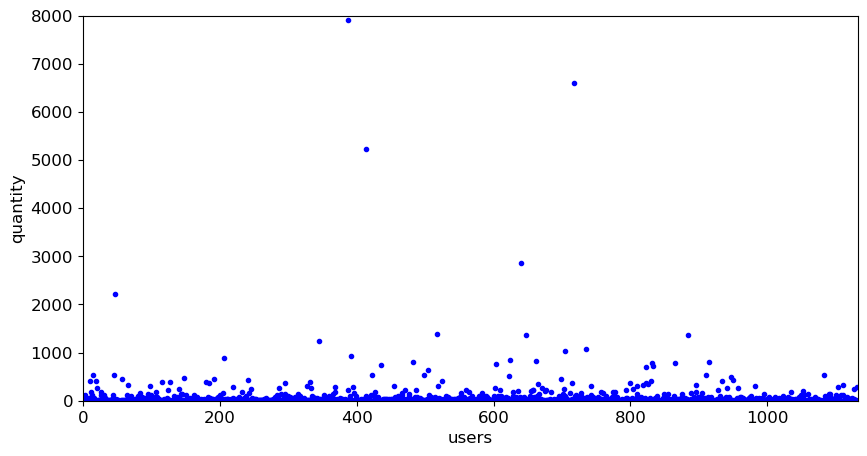

In [227]:
plt.figure(figsize=(10,5))
plt.plot(range(len(b_shuffled)),b_shuffled['repeticao'],'bo',ms=3)
plt.xlim(0, 1132)
plt.ylim(0, 8000)
plt.xlabel("users",fontsize = 12)
plt.ylabel("quantity",fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

## Analisando para timestemps = 1

In [228]:
timestemp1 = h[h['repeticao']<2]

In [229]:
#ajeitando o index
timestemp1.reset_index(inplace = True)
timestemp1.columns = ['user_id','repeticao']
lista_users_name = timestemp1['user_id'].tolist()
timestemp1 = pd.concat([timestemp1,pd.DataFrame(lista_users_name)], axis = 1)
timestemp1.columns = ['user_id','repeticao','id_timestemp']

In [230]:
#tamanho das samples dessas timestemps com tamanho 1
leitura_samples_id = []
for file in lista_arquivo:
    if(file.split("_")[0] in lista_users_name):
        nova_linha = timestemp1[timestemp1['user_id'] == file.split("_")[0]]
        nova_linha.iloc[0,2] = file.split("_")[1].split(".")[0]
        timestemp1[timestemp1['user_id'] == file.split("_")[0]] = nova_linha

In [231]:
#visualização
timestemp1.head(10)

,user_id,repeticao,id_timestemp
0,zcmg3s9,1,1543315653076
1,0dhpckv,1,1538916098382
2,1dip0jt,1,1540359594938
3,yv6n8gx,1,1543260874208
4,0f4uezb,1,1541637607517
5,0yx7i56,1,1549297833161
6,1tnew6a,1,1537303821892
7,b4dnqru,1,1540328375910
8,ylocu2a,1,1542982220706
9,2vv6lsy,1,1537280892505


In [232]:
timestemp1 = pd.concat([timestemp1,pd.DataFrame(lista_users_name),pd.DataFrame(lista_users_name)], axis = 1)

In [233]:
timestemp1.columns=['user_id','repeticao','id_timestemp','gyroscope_quantity','accelerometer_quantity']
timestemp1.index = timestemp1['user_id']
timestemp1.drop(columns=['user_id'],inplace=True)

In [234]:
for file in lista_arquivo:
    if(file.split("_")[0] in lista_users_name):
        timestemp1.loc[file.split("_")[0],'gyroscope_quantity'] = read_fileq(file,'gyroscope','MathisisGame')
        timestemp1.loc[file.split("_")[0],'accelerometer_quantity'] = read_fileq(file,'accelerometer','MathisisGame')

In [235]:
timestemp1.head(10)

,repeticao,id_timestemp,gyroscope_quantity,accelerometer_quantity
user_id,,,,
zcmg3s9,1,1543315653076,0,0
0dhpckv,1,1538916098382,265,88
1dip0jt,1,1540359594938,0,0
yv6n8gx,1,1543260874208,99,99
0f4uezb,1,1541637607517,235,2354
0yx7i56,1,1549297833161,0,0
1tnew6a,1,1537303821892,294,277
b4dnqru,1,1540328375910,0,0
ylocu2a,1,1542982220706,0,0


# Coletando timestemps com 590 gyroscopes pra cima

In [236]:
df_500 = colect_stemps(500,['gyroscope','accelerometer'])

Usuários encontrados: 1, 0hz8270
Usuários encontrados: 2, 0n1ewpo
Usuários encontrados: 3, 0sl48ao
Usuários encontrados: 4, 0sqy7ba
Usuários encontrados: 5, 141kag5
Usuários encontrados: 6, 148r1k5
Usuários encontrados: 7, 1krn0b7
Usuários encontrados: 8, 1ljg3w5
Usuários encontrados: 9, 28sxfuh
Usuários encontrados: 10, 2cf0s6s
Usuários encontrados: 11, 2h2o0iz
Usuários encontrados: 12, 2j4qo8i
Usuários encontrados: 13, 31punba
Usuários encontrados: 14, 36z77qn
Usuários encontrados: 15, 3kei971
Usuários encontrados: 16, 3vkbinh
Usuários encontrados: 17, 3xhmhs7
Usuários encontrados: 18, 3ypgstx
Usuários encontrados: 19, 4su8oxl
Usuários encontrados: 20, 4vxthrz
Usuários encontrados: 21, 58s32rk
Usuários encontrados: 22, 5fue178
Usuários encontrados: 23, 5ypuhoh
Usuários encontrados: 24, 7hxf3wx
Usuários encontrados: 25, 7ksck80
Usuários encontrados: 26, 7p7z5ex
Usuários encontrados: 27, 9rhufeh
Usuários encontrados: 28, a49ifaj
Usuários encontrados: 29, adj01eb
Usuários encontrados: 3

In [237]:
df_500

,user,user_name,metric,quantity
0,0hz8270_1537123175510.json,0hz8270,gyroscope,564
1,0hz8270_1537123175510.json,0hz8270,accelerometer,558
2,0n1ewpo_1543531607915.json,0n1ewpo,gyroscope,510
3,0n1ewpo_1543531607915.json,0n1ewpo,accelerometer,516
4,0sl48ao_1543861164227.json,0sl48ao,gyroscope,549
...,...,...,...,...
191,y2opfq8_1536468377178.json,y2opfq8,accelerometer,566
192,yqhebyt_1536398933413.json,yqhebyt,gyroscope,554
193,yqhebyt_1536398933413.json,yqhebyt,accelerometer,548
194,z3u2vz_1536614845493.json,z3u2vz,gyroscope,540


In [24]:
# df_590 = colect_stemps(590,'gyroscope')
# df_590

In [238]:
df_500.to_csv('df_500.csv', index=False)

In [239]:
# df_500 = pd.read_csv('df_500.csv')
# df_500['user_name'] = df_500['user'].str.extract(r'([^_]+)')

In [240]:
df_unique = df_500.drop_duplicates(subset='user_name')

In [241]:
df_unique

,user,user_name,metric,quantity
0,0hz8270_1537123175510.json,0hz8270,gyroscope,564
2,0n1ewpo_1543531607915.json,0n1ewpo,gyroscope,510
4,0sl48ao_1543861164227.json,0sl48ao,gyroscope,549
6,0sqy7ba_1543246696546.json,0sqy7ba,gyroscope,522
8,141kag5_1539077452611.json,141kag5,gyroscope,586
...,...,...,...,...
186,xrm6gjj_1543953976182.json,xrm6gjj,gyroscope,504
188,y2em80l_1543344138466.json,y2em80l,gyroscope,533
190,y2opfq8_1536468377178.json,y2opfq8,gyroscope,566
192,yqhebyt_1536398933413.json,yqhebyt,gyroscope,554


In [243]:
import os
import shutil

# Lista de usuários e seus arquivos JSON (exemplo simplificado)
dataset  = df_unique
# Número de usuários a serem processados (pode ser alterado para um número X)

# Caminho para a pasta onde os arquivos JSON estão localizados
source_path = './sensors_data/'

# Caminho para a pasta de destino onde os arquivos serão movidos
destination_base = './dados/'

# Número de usuários a serem processados (você pode alterar este número)
num_users = 60  # Defina quantos usuários você quer processar

# Função para mover todos os arquivos de cada usuário
def move_user_files(dataset, source_path, destination_base, num_users):
    # Iterar sobre o dataset e mover os arquivos
    for i, row in dataset.iterrows():
        if i >= num_users:
           break
        
        user_name = row['user_name']
        
        # Buscar todos os arquivos JSON que começam com o nome do usuário
        json_files = [f for f in os.listdir(source_path) if f.startswith(user_name) and f.endswith('.json')]
        
        if json_files:
            # Cria a pasta do usuário no diretório de destino
            user_folder = os.path.join(destination_base, user_name)
            os.makedirs(user_folder, exist_ok=True)

            # Mover todos os arquivos JSON correspondentes para a pasta do usuário
            for user_file in json_files:
                source_file = os.path.join(source_path, user_file)
                destination_file = os.path.join(user_folder, user_file)
                shutil.copy(source_file, destination_file)
                print(f"Arquivo {user_file} movido para {user_folder}")
        else:
            print(f"Nenhum arquivo encontrado para o usuário {user_name} no diretório {source_path}")

# Executa a função para mover os arquivos
move_user_files(dataset, source_path, destination_base, num_users)

Arquivo 0hz8270_1537120509532.json movido para ./dados/0hz8270
Arquivo 0hz8270_1537121171313.json movido para ./dados/0hz8270
Arquivo 0hz8270_1537121229928.json movido para ./dados/0hz8270
Arquivo 0hz8270_1537121294322.json movido para ./dados/0hz8270
Arquivo 0hz8270_1537121349974.json movido para ./dados/0hz8270
Arquivo 0hz8270_1537121409889.json movido para ./dados/0hz8270
Arquivo 0hz8270_1537121472939.json movido para ./dados/0hz8270
Arquivo 0hz8270_1537121529899.json movido para ./dados/0hz8270
Arquivo 0hz8270_1537121590014.json movido para ./dados/0hz8270
Arquivo 0hz8270_1537121651862.json movido para ./dados/0hz8270
Arquivo 0hz8270_1537122030128.json movido para ./dados/0hz8270
Arquivo 0hz8270_1537122090084.json movido para ./dados/0hz8270
Arquivo 0hz8270_1537122150032.json movido para ./dados/0hz8270
Arquivo 0hz8270_1537122331956.json movido para ./dados/0hz8270
Arquivo 0hz8270_1537122390284.json movido para ./dados/0hz8270
Arquivo 0hz8270_1537122450334.json movido para ./dados/